## Test with ResNet in pytorch

In [1]:
from trainer import Trainer
from constrast_trainer import ContrastTrainer
from meta_featured_trainer import MetaFeatureTrainer
from resnet import fineTuneResNet50,lessFilterResNet50, paperResNet18, nnResNet, get_ensemble_resnet, ConstrastResnet
from dpn import dpn92
from simple_cnn import get_simple_cnn
from senet import senetXX_generic
import pandas as pd
import numpy as np
%matplotlib notebook

In [2]:
train_df = pd.read_json('Data/polar_split_no_denoise_processed_train.json', dtype={'inc_angle': str})
train_df.sort_index(inplace=True)
#train_df.inc_angle = pd.to_numeric(train_df.inc_angle, errors='coerce')
#print(train_df.shape)

In [3]:
print(np.array(train_df.ix[0, 'band_mixed']).shape)

(75, 75, 4)


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [4]:
print(train_df.head(3))

                                          band_mixed inc_angle  is_iceberg
0  [[[0.2150773823, 0.2544778728, 0.7849226177, 0...   43.9239           0
1  [[[0.4039837988, 0.20397305870000002, 0.596016...   38.1562           0
2  [[[0.2546405418, 0.2809726554, 0.7453594582, 0...   45.2859           1


In [5]:
from sklearn.model_selection import KFold
fold_num = 5

In [6]:
import torch
from torch.optim import lr_scheduler
import gc
gc.enable()

## Cross Validation

## cross validate less filter ResNet5

In [7]:
#transform_inc_angle = pd.read_csv('Data/inc_angle_train.csv')
#train_df['inc_angle'] = transform_inc_angle['inc_angle']
#train_df['angle_sg_0'] = np.zeros((train_df.shape[0], ))
#train_df['angle_sg_1'] = np.zeros((train_df.shape[0], ))
#train_df['angle_sg_2'] = np.zeros((train_df.shape[0], ))
#train_df = train_df[train_df.inc_angle != 0.]
#train_df.reset_index(drop=True, inplace=True)

In [8]:
train_df['inc_angle'] = pd.to_numeric(train_df['inc_angle'], errors='coerce')

In [9]:
test_df = pd.read_json('Data/public_lb_1229_cpl_polar_test.json', dtype={'inc_angle': str})
test_df.sort_index(inplace=True)
print(test_df.head(5))


test_df['inc_angle'] = pd.to_numeric(test_df['inc_angle'], errors='coerce')
test_df.is_iceberg = [1.0 if v >= .5 else 0. for v in test_df.is_iceberg.values]
print(test_df.head(5))
new_train_df = pd.concat([train_df, test_df]).reset_index(drop=True) 
del train_df, test_df

train_df = new_train_df

                                          band_mixed inc_angle  is_iceberg
0  [[[0.3602381271, 0.3185865893, 0.6397618729, 0...   34.9664    0.000000
1  [[[0.4048886681, 0.28734042120000003, 0.595111...   34.4739    0.999914
2  [[[0.3082910753, 0.21094702810000002, 0.691708...   33.6383    0.999990
3  [[[0.287055624, 0.2732625128, 0.712944376, 0.7...   41.1076    0.000000
4  [[[0.3729440885, 0.3071171816, 0.6270559115000...   34.9664    0.000000
                                          band_mixed  inc_angle  is_iceberg
0  [[[0.3602381271, 0.3185865893, 0.6397618729, 0...    34.9664         0.0
1  [[[0.4048886681, 0.28734042120000003, 0.595111...    34.4739         1.0
2  [[[0.3082910753, 0.21094702810000002, 0.691708...    33.6383         1.0
3  [[[0.287055624, 0.2732625128, 0.712944376, 0.7...    41.1076         0.0
4  [[[0.3729440885, 0.3071171816, 0.6270559115000...    34.9664         0.0


In [10]:
import random
seed=519
random.seed(seed)
np.random.seed(seed)
kf = KFold(n_splits=fold_num, shuffle=True, random_state=seed)

reheat_times = 1
is_transfer_learning = False
pretrained_model = None #'Trained_model/dae.db'
skip_list = []

gpu: 0  available: True
(918, 1)


<IPython.core.display.Javascript object>


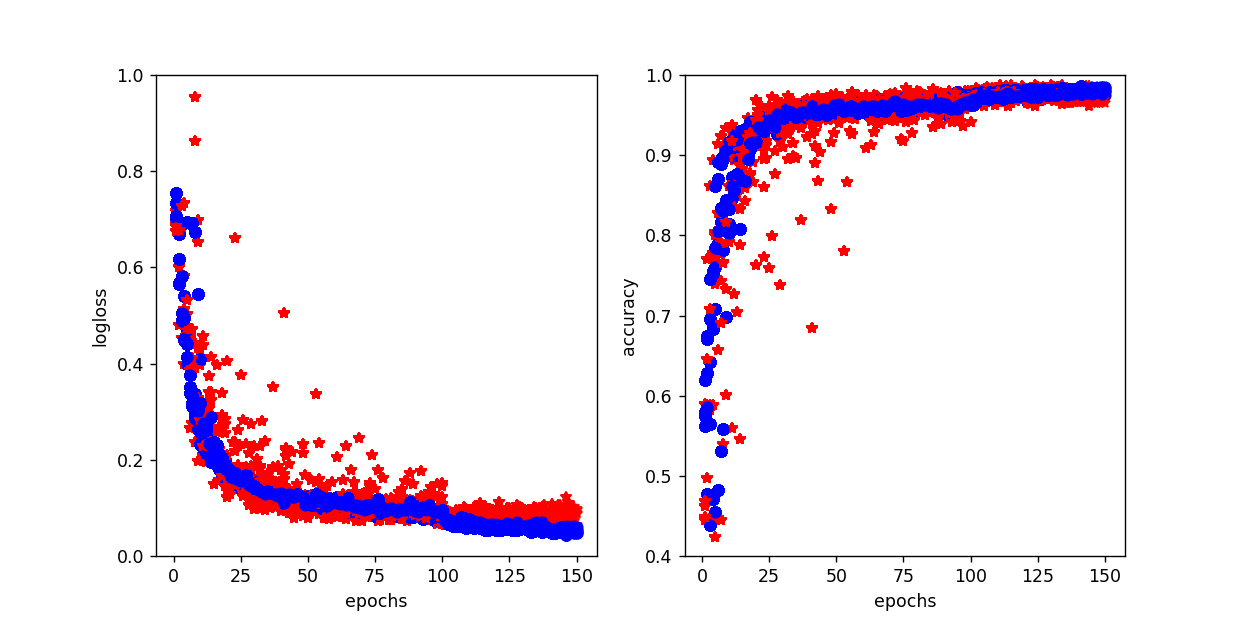

epoch= 1: Train set: Average loss: 0.6949, Accuracy: 2276/3672 (61.98%)
Valid set: Average loss: 0.7168, Accuracy: 425/918 (46.30%)
Best single model loss:  0.7167836983998617
epoch= 2: Train set: Average loss: 0.6690, Accuracy: 2478/3672 (67.48%)
Valid set: Average loss: 0.6017, Accuracy: 576/918 (62.75%)
Best single model loss:  0.6017344236373902
epoch= 3: Train set: Average loss: 0.5815, Accuracy: 2557/3672 (69.64%)
Valid set: Average loss: 0.6838, Accuracy: 535/918 (58.28%)
Best single model loss:  0.6017344236373902
epoch= 4: Train set: Average loss: 0.5406, Accuracy: 2521/3672 (68.65%)
Valid set: Average loss: 0.5814, Accuracy: 649/918 (70.70%)
Best single model loss:  0.5813505053520203
epoch= 5: Train set: Average loss: 0.4699, Accuracy: 2793/3672 (76.06%)
Valid set: Average loss: 0.5032, Accuracy: 709/918 (77.23%)
Best single model loss:  0.5031664907932282
epoch= 6: Train set: Average loss: 0.3982, Accuracy: 2902/3672 (79.03%)
Valid set: Average loss: 0.4565, Accuracy: 701/9

Valid set: Average loss: 0.1310, Accuracy: 885/918 (96.41%)
Best single model loss:  0.08915060665458441
epoch= 48: Train set: Average loss: 0.1137, Accuracy: 3521/3672 (95.89%)
Valid set: Average loss: 0.0843, Accuracy: 895/918 (97.49%)
Best single model loss:  0.08433502117792765
epoch= 49: Train set: Average loss: 0.1213, Accuracy: 3499/3672 (95.29%)
Valid set: Average loss: 0.1279, Accuracy: 868/918 (94.55%)
Best single model loss:  0.08433502117792765
epoch= 50: Train set: Average loss: 0.1247, Accuracy: 3497/3672 (95.23%)
Valid set: Average loss: 0.1035, Accuracy: 890/918 (96.95%)
Best single model loss:  0.08433502117792765
epoch= 51: Train set: Average loss: 0.1093, Accuracy: 3524/3672 (95.97%)
Valid set: Average loss: 0.1129, Accuracy: 880/918 (95.86%)
Best single model loss:  0.08433502117792765
epoch= 52: Train set: Average loss: 0.1146, Accuracy: 3522/3672 (95.92%)
Valid set: Average loss: 0.1093, Accuracy: 882/918 (96.08%)
Best single model loss:  0.08433502117792765
epoch

epoch= 94: Train set: Average loss: 0.0949, Accuracy: 3525/3672 (96.00%)
Valid set: Average loss: 0.0810, Accuracy: 896/918 (97.60%)
Best single model loss:  0.07288837855060895
epoch= 95: Train set: Average loss: 0.0983, Accuracy: 3526/3672 (96.02%)
Valid set: Average loss: 0.0960, Accuracy: 892/918 (97.17%)
Best single model loss:  0.07288837855060895
epoch= 96: Train set: Average loss: 0.0926, Accuracy: 3532/3672 (96.19%)
Valid set: Average loss: 0.0762, Accuracy: 899/918 (97.93%)
Best single model loss:  0.07288837855060895
epoch= 97: Train set: Average loss: 0.0956, Accuracy: 3534/3672 (96.24%)
Valid set: Average loss: 0.0894, Accuracy: 895/918 (97.49%)
Best single model loss:  0.07288837855060895
epoch= 98: Train set: Average loss: 0.0947, Accuracy: 3542/3672 (96.46%)
Valid set: Average loss: 0.0680, Accuracy: 900/918 (98.04%)
Best single model loss:  0.06801084286222855
epoch= 99: Train set: Average loss: 0.0933, Accuracy: 3540/3672 (96.41%)
Valid set: Average loss: 0.0757, Accu

epoch= 140: Train set: Average loss: 0.0653, Accuracy: 3587/3672 (97.69%)
Valid set: Average loss: 0.0652, Accuracy: 901/918 (98.15%)
Best single model loss:  0.05816717385314405
epoch= 141: Train set: Average loss: 0.0592, Accuracy: 3587/3672 (97.69%)
Valid set: Average loss: 0.0645, Accuracy: 902/918 (98.26%)
Best single model loss:  0.05816717385314405
epoch= 142: Train set: Average loss: 0.0635, Accuracy: 3582/3672 (97.55%)
Valid set: Average loss: 0.0722, Accuracy: 900/918 (98.04%)
Best single model loss:  0.05816717385314405
epoch= 143: Train set: Average loss: 0.0657, Accuracy: 3583/3672 (97.58%)
Valid set: Average loss: 0.0705, Accuracy: 905/918 (98.58%)
Best single model loss:  0.05816717385314405
epoch= 144: Train set: Average loss: 0.0648, Accuracy: 3586/3672 (97.66%)
Valid set: Average loss: 0.0648, Accuracy: 905/918 (98.58%)
Best single model loss:  0.05816717385314405
epoch= 145: Train set: Average loss: 0.0649, Accuracy: 3578/3672 (97.44%)
Valid set: Average loss: 0.0711

epoch= 36: Train set: Average loss: 0.1184, Accuracy: 3529/3672 (96.11%)
Valid set: Average loss: 0.1448, Accuracy: 877/918 (95.53%)
Best single model loss:  0.13044226840138434
epoch= 37: Train set: Average loss: 0.1278, Accuracy: 3498/3672 (95.26%)
Valid set: Average loss: 0.1573, Accuracy: 865/918 (94.23%)
Best single model loss:  0.13044226840138434
epoch= 38: Train set: Average loss: 0.1237, Accuracy: 3507/3672 (95.51%)
Valid set: Average loss: 0.1162, Accuracy: 875/918 (95.32%)
Best single model loss:  0.11620843845109145
epoch= 39: Train set: Average loss: 0.1194, Accuracy: 3522/3672 (95.92%)
Valid set: Average loss: 0.1240, Accuracy: 878/918 (95.64%)
Best single model loss:  0.11620843845109145
epoch= 40: Train set: Average loss: 0.1122, Accuracy: 3517/3672 (95.78%)
Valid set: Average loss: 0.1541, Accuracy: 866/918 (94.34%)
Best single model loss:  0.11620843845109145
epoch= 41: Train set: Average loss: 0.1240, Accuracy: 3508/3672 (95.53%)
Valid set: Average loss: 0.1598, Accu

epoch= 82: Train set: Average loss: 0.0888, Accuracy: 3553/3672 (96.76%)
Valid set: Average loss: 0.1009, Accuracy: 876/918 (95.42%)
Best single model loss:  0.08005680963397026
epoch= 83: Train set: Average loss: 0.0846, Accuracy: 3562/3672 (97.00%)
Valid set: Average loss: 0.0874, Accuracy: 882/918 (96.08%)
Best single model loss:  0.08005680963397026
epoch= 84: Train set: Average loss: 0.0854, Accuracy: 3566/3672 (97.11%)
Valid set: Average loss: 0.0954, Accuracy: 883/918 (96.19%)
Best single model loss:  0.08005680963397026
epoch= 85: Train set: Average loss: 0.0869, Accuracy: 3569/3672 (97.19%)
Valid set: Average loss: 0.1227, Accuracy: 874/918 (95.21%)
Best single model loss:  0.08005680963397026
epoch= 86: Train set: Average loss: 0.0823, Accuracy: 3568/3672 (97.17%)
Valid set: Average loss: 0.1559, Accuracy: 859/918 (93.57%)
Best single model loss:  0.08005680963397026
epoch= 87: Train set: Average loss: 0.0965, Accuracy: 3550/3672 (96.68%)
Valid set: Average loss: 0.1066, Accu

epoch= 128: Train set: Average loss: 0.0579, Accuracy: 3598/3672 (97.98%)
Valid set: Average loss: 0.0921, Accuracy: 890/918 (96.95%)
Best single model loss:  0.07642136033003528
epoch= 129: Train set: Average loss: 0.0557, Accuracy: 3605/3672 (98.18%)
Valid set: Average loss: 0.0895, Accuracy: 890/918 (96.95%)
Best single model loss:  0.07642136033003528
epoch= 130: Train set: Average loss: 0.0579, Accuracy: 3593/3672 (97.85%)
Valid set: Average loss: 0.0839, Accuracy: 891/918 (97.06%)
Best single model loss:  0.07642136033003528
epoch= 131: Train set: Average loss: 0.0563, Accuracy: 3603/3672 (98.12%)
Valid set: Average loss: 0.0944, Accuracy: 888/918 (96.73%)
Best single model loss:  0.07642136033003528
epoch= 132: Train set: Average loss: 0.0611, Accuracy: 3595/3672 (97.90%)
Valid set: Average loss: 0.0885, Accuracy: 890/918 (96.95%)
Best single model loss:  0.07642136033003528
epoch= 133: Train set: Average loss: 0.0544, Accuracy: 3606/3672 (98.20%)
Valid set: Average loss: 0.0959

epoch= 24: Train set: Average loss: 0.1534, Accuracy: 3440/3672 (93.68%)
Valid set: Average loss: 0.1738, Accuracy: 856/918 (93.25%)
Best single model loss:  0.14023222426573437
epoch= 25: Train set: Average loss: 0.1564, Accuracy: 3464/3672 (94.34%)
Valid set: Average loss: 0.1538, Accuracy: 882/918 (96.08%)
Best single model loss:  0.14023222426573437
epoch= 26: Train set: Average loss: 0.1529, Accuracy: 3451/3672 (93.98%)
Valid set: Average loss: 0.2825, Accuracy: 734/918 (79.96%)
Best single model loss:  0.14023222426573437
epoch= 27: Train set: Average loss: 0.1421, Accuracy: 3470/3672 (94.50%)
Valid set: Average loss: 0.1471, Accuracy: 870/918 (94.77%)
Best single model loss:  0.14023222426573437
epoch= 28: Train set: Average loss: 0.1523, Accuracy: 3460/3672 (94.23%)
Valid set: Average loss: 0.1655, Accuracy: 860/918 (93.68%)
Best single model loss:  0.14023222426573437
epoch= 29: Train set: Average loss: 0.1269, Accuracy: 3493/3672 (95.13%)
Valid set: Average loss: 0.2753, Accu

Valid set: Average loss: 0.1000, Accuracy: 884/918 (96.30%)
Best single model loss:  0.07421250270369152
epoch= 71: Train set: Average loss: 0.0958, Accuracy: 3537/3672 (96.32%)
Valid set: Average loss: 0.0984, Accuracy: 886/918 (96.51%)
Best single model loss:  0.07421250270369152
epoch= 72: Train set: Average loss: 0.0929, Accuracy: 3548/3672 (96.62%)
Valid set: Average loss: 0.0840, Accuracy: 892/918 (97.17%)
Best single model loss:  0.07421250270369152
epoch= 73: Train set: Average loss: 0.0874, Accuracy: 3564/3672 (97.06%)
Valid set: Average loss: 0.1469, Accuracy: 873/918 (95.10%)
Best single model loss:  0.07421250270369152
epoch= 74: Train set: Average loss: 0.0966, Accuracy: 3538/3672 (96.35%)
Valid set: Average loss: 0.0945, Accuracy: 892/918 (97.17%)
Best single model loss:  0.07421250270369152
epoch= 75: Train set: Average loss: 0.0953, Accuracy: 3550/3672 (96.68%)
Valid set: Average loss: 0.0971, Accuracy: 882/918 (96.08%)
Best single model loss:  0.07421250270369152
epoch

Valid set: Average loss: 0.1040, Accuracy: 893/918 (97.28%)
Best single model loss:  0.07048591789789498
epoch= 117: Train set: Average loss: 0.0536, Accuracy: 3605/3672 (98.18%)
Valid set: Average loss: 0.0961, Accuracy: 890/918 (96.95%)
Best single model loss:  0.07048591789789498
epoch= 118: Train set: Average loss: 0.0611, Accuracy: 3589/3672 (97.74%)
Valid set: Average loss: 0.0953, Accuracy: 892/918 (97.17%)
Best single model loss:  0.07048591789789498
epoch= 119: Train set: Average loss: 0.0581, Accuracy: 3596/3672 (97.93%)
Valid set: Average loss: 0.0951, Accuracy: 891/918 (97.06%)
Best single model loss:  0.07048591789789498
epoch= 120: Train set: Average loss: 0.0639, Accuracy: 3595/3672 (97.90%)
Valid set: Average loss: 0.0913, Accuracy: 893/918 (97.28%)
Best single model loss:  0.07048591789789498
epoch= 121: Train set: Average loss: 0.0603, Accuracy: 3596/3672 (97.93%)
Valid set: Average loss: 0.1122, Accuracy: 886/918 (96.51%)
Best single model loss:  0.07048591789789498


Valid set: Average loss: 0.2256, Accuracy: 843/918 (91.83%)
Best single model loss:  0.2255773221453031
epoch= 13: Train set: Average loss: 0.2216, Accuracy: 3376/3672 (91.94%)
Valid set: Average loss: 0.2370, Accuracy: 837/918 (91.18%)
Best single model loss:  0.2255773221453031
epoch= 14: Train set: Average loss: 0.1954, Accuracy: 3414/3672 (92.97%)
Valid set: Average loss: 0.2857, Accuracy: 815/918 (88.78%)
Best single model loss:  0.2255773221453031
epoch= 15: Train set: Average loss: 0.2003, Accuracy: 3409/3672 (92.84%)
Valid set: Average loss: 0.2082, Accuracy: 850/918 (92.59%)
Best single model loss:  0.20821564917763075
epoch= 16: Train set: Average loss: 0.1897, Accuracy: 3423/3672 (93.22%)
Valid set: Average loss: 0.2203, Accuracy: 833/918 (90.74%)
Best single model loss:  0.20821564917763075
epoch= 17: Train set: Average loss: 0.1978, Accuracy: 3411/3672 (92.89%)
Valid set: Average loss: 0.2085, Accuracy: 840/918 (91.50%)
Best single model loss:  0.20821564917763075
epoch= 1

Best single model loss:  0.08470184989273548
epoch= 59: Train set: Average loss: 0.1140, Accuracy: 3515/3672 (95.72%)
Valid set: Average loss: 0.0861, Accuracy: 890/918 (96.95%)
Best single model loss:  0.08470184989273548
epoch= 60: Train set: Average loss: 0.1000, Accuracy: 3540/3672 (96.41%)
Valid set: Average loss: 0.1064, Accuracy: 882/918 (96.08%)
Best single model loss:  0.08470184989273548
epoch= 61: Train set: Average loss: 0.1038, Accuracy: 3523/3672 (95.94%)
Valid set: Average loss: 0.0864, Accuracy: 895/918 (97.49%)
Best single model loss:  0.08470184989273548
epoch= 62: Train set: Average loss: 0.1121, Accuracy: 3523/3672 (95.94%)
Valid set: Average loss: 0.1028, Accuracy: 884/918 (96.30%)
Best single model loss:  0.08470184989273548
epoch= 63: Train set: Average loss: 0.1034, Accuracy: 3537/3672 (96.32%)
Valid set: Average loss: 0.1065, Accuracy: 885/918 (96.41%)
Best single model loss:  0.08470184989273548
epoch= 64: Train set: Average loss: 0.0984, Accuracy: 3547/3672 (

epoch= 105: Train set: Average loss: 0.0659, Accuracy: 3579/3672 (97.47%)
Valid set: Average loss: 0.0819, Accuracy: 898/918 (97.82%)
Best single model loss:  0.07901024012826383
epoch= 106: Train set: Average loss: 0.0734, Accuracy: 3577/3672 (97.41%)
Valid set: Average loss: 0.0916, Accuracy: 896/918 (97.60%)
Best single model loss:  0.07901024012826383
epoch= 107: Train set: Average loss: 0.0652, Accuracy: 3589/3672 (97.74%)
Valid set: Average loss: 0.0843, Accuracy: 896/918 (97.60%)
Best single model loss:  0.07901024012826383
epoch= 108: Train set: Average loss: 0.0608, Accuracy: 3591/3672 (97.79%)
Valid set: Average loss: 0.0881, Accuracy: 895/918 (97.49%)
Best single model loss:  0.07901024012826383
epoch= 109: Train set: Average loss: 0.0633, Accuracy: 3580/3672 (97.49%)
Valid set: Average loss: 0.0866, Accuracy: 893/918 (97.28%)
Best single model loss:  0.07901024012826383
epoch= 110: Train set: Average loss: 0.0649, Accuracy: 3587/3672 (97.69%)
Valid set: Average loss: 0.0844

gpu: 0  available: True
(918, 1)
epoch= 1: Train set: Average loss: 0.7065, Accuracy: 2128/3672 (57.95%)
Valid set: Average loss: 0.6854, Accuracy: 430/918 (46.84%)
Best single model loss:  0.6854336142539978
epoch= 2: Train set: Average loss: 0.6178, Accuracy: 2465/3672 (67.13%)
Valid set: Average loss: 0.6770, Accuracy: 593/918 (64.60%)
Best single model loss:  0.6770077486832936
epoch= 3: Train set: Average loss: 0.5057, Accuracy: 2738/3672 (74.56%)
Valid set: Average loss: 0.7279, Accuracy: 650/918 (70.81%)
Best single model loss:  0.6770077486832936
epoch= 4: Train set: Average loss: 0.4957, Accuracy: 2774/3672 (75.54%)
Valid set: Average loss: 0.5128, Accuracy: 714/918 (77.78%)
Best single model loss:  0.5128071367740631
epoch= 5: Train set: Average loss: 0.4402, Accuracy: 2882/3672 (78.49%)
Valid set: Average loss: 0.4413, Accuracy: 738/918 (80.39%)
Best single model loss:  0.4413114349047343
epoch= 6: Train set: Average loss: 0.3774, Accuracy: 2959/3672 (80.58%)
Valid set: Aver

Valid set: Average loss: 0.0962, Accuracy: 891/918 (97.06%)
Best single model loss:  0.09358285615841548
epoch= 48: Train set: Average loss: 0.1233, Accuracy: 3501/3672 (95.34%)
Valid set: Average loss: 0.2142, Accuracy: 841/918 (91.61%)
Best single model loss:  0.09358285615841548
epoch= 49: Train set: Average loss: 0.1067, Accuracy: 3535/3672 (96.27%)
Valid set: Average loss: 0.0945, Accuracy: 892/918 (97.17%)
Best single model loss:  0.09358285615841548
epoch= 50: Train set: Average loss: 0.1150, Accuracy: 3522/3672 (95.92%)
Valid set: Average loss: 0.0855, Accuracy: 890/918 (96.95%)
Best single model loss:  0.08554821684956551
epoch= 51: Train set: Average loss: 0.1069, Accuracy: 3537/3672 (96.32%)
Valid set: Average loss: 0.1587, Accuracy: 863/918 (94.01%)
Best single model loss:  0.08554821684956551
epoch= 52: Train set: Average loss: 0.1119, Accuracy: 3512/3672 (95.64%)
Valid set: Average loss: 0.1116, Accuracy: 893/918 (97.28%)
Best single model loss:  0.08554821684956551
epoch

epoch= 94: Train set: Average loss: 0.0968, Accuracy: 3522/3672 (95.92%)
Valid set: Average loss: 0.0796, Accuracy: 897/918 (97.71%)
Best single model loss:  0.07714431177203854
epoch= 95: Train set: Average loss: 0.1061, Accuracy: 3517/3672 (95.78%)
Valid set: Average loss: 0.1336, Accuracy: 870/918 (94.77%)
Best single model loss:  0.07714431177203854
epoch= 96: Train set: Average loss: 0.0954, Accuracy: 3541/3672 (96.43%)
Valid set: Average loss: 0.0885, Accuracy: 888/918 (96.73%)
Best single model loss:  0.07714431177203854
epoch= 97: Train set: Average loss: 0.0910, Accuracy: 3540/3672 (96.41%)
Valid set: Average loss: 0.0951, Accuracy: 890/918 (96.95%)
Best single model loss:  0.07714431177203854
epoch= 98: Train set: Average loss: 0.0934, Accuracy: 3548/3672 (96.62%)
Valid set: Average loss: 0.1006, Accuracy: 891/918 (97.06%)
Best single model loss:  0.07714431177203854
epoch= 99: Train set: Average loss: 0.0902, Accuracy: 3548/3672 (96.62%)
Valid set: Average loss: 0.0843, Accu

epoch= 140: Train set: Average loss: 0.0566, Accuracy: 3600/3672 (98.04%)
Valid set: Average loss: 0.0772, Accuracy: 897/918 (97.71%)
Best single model loss:  0.0714154920152699
epoch= 141: Train set: Average loss: 0.0570, Accuracy: 3586/3672 (97.66%)
Valid set: Average loss: 0.0746, Accuracy: 895/918 (97.49%)
Best single model loss:  0.0714154920152699
epoch= 142: Train set: Average loss: 0.0576, Accuracy: 3593/3672 (97.85%)
Valid set: Average loss: 0.0794, Accuracy: 895/918 (97.49%)
Best single model loss:  0.0714154920152699
epoch= 143: Train set: Average loss: 0.0585, Accuracy: 3588/3672 (97.71%)
Valid set: Average loss: 0.0835, Accuracy: 895/918 (97.49%)
Best single model loss:  0.0714154920152699
epoch= 144: Train set: Average loss: 0.0514, Accuracy: 3590/3672 (97.77%)
Valid set: Average loss: 0.0844, Accuracy: 893/918 (97.28%)
Best single model loss:  0.0714154920152699
epoch= 145: Train set: Average loss: 0.0607, Accuracy: 3587/3672 (97.69%)
Valid set: Average loss: 0.0838, Acc

In [11]:
counter  = 1
for train_index, valid_index in kf.split(train_df):
    
    if counter in skip_list:
        counter += 1
        continue
        
    model = get_ensemble_resnet() #lessFilterResNet50() #get_simple_cnn() #lessFilterResNet50() #nnResNet(meta_features=1)  #dpn92(num_classes=1)
    model_name = 'Trained_model/ens_resnet_cpl_' + str(counter) + '.db'
    #load_model_name = 'Trained_model/less_filter_resnet50_bugfixed_load_bestcp_' + str(counter) + '.db'
    
    #print(list(model.parameters()))
    train = train_df.loc[train_index].reset_index(drop=True)
    valid = train_df.loc[valid_index].reset_index(drop=True)
    
    data_augmentation_args = {
        'mirror': False, # not useful here
        'rotate': True,
        'scale': True,
        'translation': True,
        'crop': False,
        #'color jitter' : True,
    }
    
    for i in range(reheat_times):
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)
      
        tr = Trainer(
                model,
                optimizer,
                epochs=150,
                milestones=[100],
                #epochs=1300,
                #milestones=[300, 1000, 1200],
                gamma=0.2,
                batch_size=64, 
                use_cuda=True, 
                gpu_idx=0,
                best_model_name=model_name,
                verbose=0,
                start_valid_ensemble_epoch=60)
        
        #tr.load_checkpoint(load_model_name)
        
        if i != 0:
            tr.load_checkpoint()
        else:
            if pretrained_model is not None:
                tr.load(pretrained_model)
            
        tr.train(train, valid_df=valid, test_df=None, test_ids=None,
                 is_transfer_learning=is_transfer_learning, 
                 data_augmentation_args=data_augmentation_args, do_sa=False, t_start=0.005, start_epoch=1300)
        del optimizer, tr
        gc.collect()
        
    counter += 1
    del model
    gc.collect()

## Train with pseudo labeling

In [9]:
test_df = pd.read_json('Data/public_lb_1229_cpl_polar_test.json', dtype={'inc_angle': str})
test_df.sort_index(inplace=True)
print(test_df.tail(5))

                                             band_mixed      inc_angle  \
2981  [[[0.3182368602, 0.3494481393, 0.6817631398, 0...  42.2076492164   
2982  [[[0.2598733448, 0.2891004493, 0.7401266552, 0...  47.0199549636   
2983  [[[0.1541470346, 0.1611042348, 0.8458529654, 0...        42.5075   
2984  [[[0.3386115126, 0.2633779679, 0.6613884874, 0...        34.8688   
2985  [[[0.2157230457, 0.2665205054, 0.7842769543, 0...  37.1902255041   

      is_iceberg  
2981    0.998969  
2982    0.000000  
2983    0.000220  
2984    0.999999  
2985    0.000000  


In [10]:
test_df.loc[:, 'inc_angle'] = pd.to_numeric(test_df['inc_angle'], errors='coerce')

In [11]:
mask = (test_df['is_iceberg'] >= .98) | (test_df['is_iceberg'] <= .02) # mask for confident pseudo labels

In [12]:
print(test_df[mask].shape)
#print(test_df[mask].is_iceberg.value_counts())

(2896, 3)


In [13]:
print(test_df[~mask].shape)

(90, 3)


In [14]:
print(test_df.head(3))

                                          band_mixed  inc_angle  is_iceberg
0  [[[0.3602381271, 0.3185865893, 0.6397618729, 0...  34.966400    0.000000
1  [[[0.2777184498, 0.3268824053, 0.7222815502000...  41.045646    0.999914
2  [[[0.2239339407, 0.2377414478, 0.7760660593, 0...  40.712985    0.999990


In [15]:
test_df.is_iceberg = [1.0 if v >= .5 else 0. for v in test_df.is_iceberg.values]

#### Confident records:
* 1.0: 1143
* 0.0: 1089

In [16]:
import random
seed=1234
random.seed(seed)
np.random.seed(seed)
kf = KFold(n_splits=fold_num, shuffle=True, random_state=seed)

reheat_times = 1
is_transfer_learning = False
pretrained_model = None #'Trained_model/dae.db'
skip_list = []

In [17]:
train_df['is_pseudo'] = np.repeat(0.0, train_df.shape[0])
test_df['is_pseudo'] = np.repeat(0.0, test_df.shape[0]) # treat reliable ones as real labels
train_df = pd.concat([train_df, test_df]).reset_index(drop=True) 
#del test_df
#test_df.loc[mask, 'is_iceberg'] = test_df.loc[mask, 'is_iceberg'].apply(lambda x: 1.0 if x >= .5 else 0.0)
#test_df.loc[~mask, 'is_pseudo'] = np.repeat(1.0, (test_df[~mask].shape[0],)) 
#test_df['is_pseudo'] = np.repeat(1.0, test_df.shape[0]) 

gpu: 0  available: True
(918, 1)


<IPython.core.display.Javascript object>


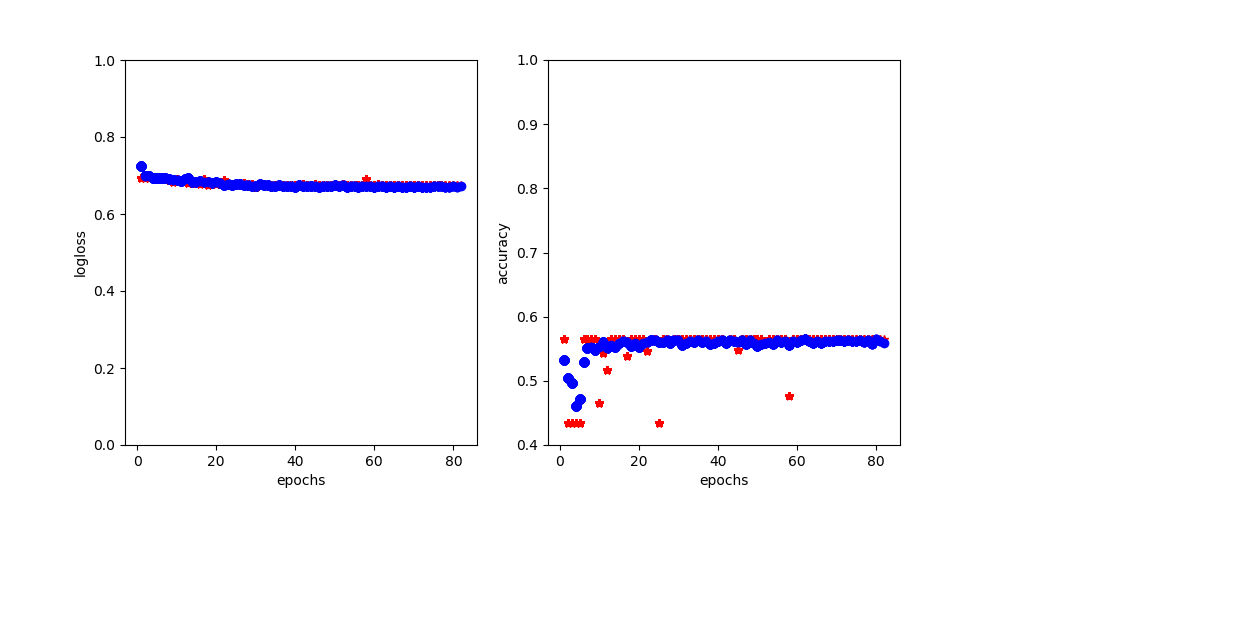

epoch= 1: Train set: Average loss: 0.7250, Accuracy: 1955/3672 (53.24%)
Valid set: Average loss: 0.6931, Accuracy: 519/918 (56.54%)
Best single model loss:  0.6931434075037638
epoch= 2: Train set: Average loss: 0.6987, Accuracy: 1855/3672 (50.52%)
Valid set: Average loss: 0.6932, Accuracy: 399/918 (43.46%)
Best single model loss:  0.6931434075037638
epoch= 3: Train set: Average loss: 0.6995, Accuracy: 1824/3672 (49.67%)
Valid set: Average loss: 0.6931, Accuracy: 399/918 (43.46%)
Best single model loss:  0.6931434075037638
epoch= 4: Train set: Average loss: 0.6933, Accuracy: 1691/3672 (46.05%)
Valid set: Average loss: 0.6931, Accuracy: 399/918 (43.46%)
Best single model loss:  0.6931434075037638
epoch= 5: Train set: Average loss: 0.6931, Accuracy: 1734/3672 (47.22%)
Valid set: Average loss: 0.6931, Accuracy: 399/918 (43.46%)
Best single model loss:  0.6931434075037638
epoch= 6: Train set: Average loss: 0.6939, Accuracy: 1945/3672 (52.97%)
Valid set: Average loss: 0.6931, Accuracy: 519/9

epoch= 48: Train set: Average loss: 0.6722, Accuracy: 2068/3672 (56.32%)
Valid set: Average loss: 0.6745, Accuracy: 519/918 (56.54%)
Best single model loss:  0.6708997925122578
epoch= 49: Train set: Average loss: 0.6728, Accuracy: 2050/3672 (55.83%)
Valid set: Average loss: 0.6754, Accuracy: 519/918 (56.54%)
Best single model loss:  0.6708997925122578
epoch= 50: Train set: Average loss: 0.6741, Accuracy: 2035/3672 (55.42%)
Valid set: Average loss: 0.6749, Accuracy: 519/918 (56.54%)
Best single model loss:  0.6708997925122578
epoch= 51: Train set: Average loss: 0.6726, Accuracy: 2044/3672 (55.66%)
Valid set: Average loss: 0.6746, Accuracy: 519/918 (56.54%)
Best single model loss:  0.6708997925122578
epoch= 52: Train set: Average loss: 0.6743, Accuracy: 2052/3672 (55.88%)
Valid set: Average loss: 0.6792, Accuracy: 514/918 (55.99%)
Best single model loss:  0.6708997925122578
epoch= 53: Train set: Average loss: 0.6706, Accuracy: 2058/3672 (56.05%)
Valid set: Average loss: 0.6745, Accuracy:

KeyboardInterrupt: 

In [18]:
counter = 1

for train_index, valid_index in kf.split(train_df):
    
    if counter in skip_list:
        counter += 1
        continue
        
    model = lessFilterResNet50(meta_features=1) #senetXX_generic(num_rgb=3)   #dpn92(num_classes=1) #lessFilterResNet50() #paperResNet18() #lessFilterResNet50()
    model_name = 'Trained_model/resnet_' + 'cpl_n_valid_' + str(counter) + '.db'
    #load_model_name = 'Trained_model/dpn_origin_' + str(counter) + '.db'
    
    train = train_df.loc[train_index].reset_index(drop=True)
    valid = train_df.loc[valid_index].reset_index(drop=True)
    
    ##train = pd.concat([train, test_df]).reset_index(drop=True)
    #.sample(frac=.8, random_state=counter)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.001)
    
    data_augmentation_args = {
        'mirror': False, # not useful here
        'rotate': True,
        'scale': True,
        'translation': True,
    }
    
    tr = Trainer(
            model,
            optimizer,
            epochs=200,
            milestones=[100],
            gamma=0.2,
            batch_size=64, 
            use_cuda=True, 
            gpu_idx=0,
            best_model_name=model_name,
            verbose=0,
            start_valid_ensemble_epoch=60)

    tr.train(train, valid_df=valid, test_df=None, test_ids=None,
             pl_enabled=False, pl_beta=.8, pl_beta_end=.2, pl_dec_start=800, pl_dec_end=800,
             is_transfer_learning=is_transfer_learning, 
             data_augmentation_args=data_augmentation_args, do_sa=False, t_start=0.005, start_epoch=1300)
    
    del optimizer, tr, model, train, valid
    gc.collect()
        
    counter += 1   

In [ ]:
del optimizer, tr, model

#### 20171208 Five fold records (dpn, no scale)
* best val loss: 0.2065, 0.1693, 0.1984, 0.2398, 0.2104
* essem avg loss: 0.2147, 0.2068, 0.2223, 0.2530, 0.2170
* avg loss: 0.2048
* accuracies: 91.28%, 91.59%, 91.59%, 87.85%, 91.88%
* avg acc: 90.84%

Public LB: 0. (test augmentation)

Comment: Might overfit to the valid set, maybe fine-tune with smaller learning rate would be better

#### 20171206 Five fold records (dpn, no dropout)
* losses: 0.194, 0.184, 0.2051, 0.2414, 0.223
* avg loss: 0.2095
* accuracies: 90.65%, 92.21%, 88.47%, 90.03%, 89.38%
* avg acc: 90.15%

Public LB: 0. (test augmentation)

Comment: Might overfit to the valid set, maybe fine-tune with smaller learning rate would be better

#### 20171205 Five fold records (dpn, no dropout)
* losses: 0.184, 0.1824, 0.216, 0.2571, 0.229
* avg loss: 0.2137
* accuracies: 89.41%, 90.03%, 88.47%, 90.65%, 90.31%
* avg acc: 89.774%

Public LB: 0. (test augmentation)

Comment: Might overfit to the valid set, maybe fine-tune with smaller learning rate would be better

#### 20171123 Five fold records
* losses: 0.224, 0.194, 0.233, 0.233, 0.234
* avg loss: 0.223
* accuracies: 91.59%, 91.90%, 89.41%, 91.28%, 91.56%
* avg acc: 91.148%

Public LB: 0.1686 (test augmentation)

Comment: Might overfit to the valid set, maybe fine-tune with smaller learning rate would be better

#### 201710 Five fold records
* losses: 0.229, 0.198, 0.208, 0.22, 0.224
* avg loss: 0.2158
* accuracies: 90.65%, 91.90%, 91.59%, 89.10%, 90.31%
* avg acc: 90.71%

Public LB: 0.1685 \ 0.1602 (test augmentation)

## Fine-tune with trained models

In [ ]:
import random
random.seed(519)
np.random.seed(519)
kf = KFold(n_splits=fold_num, shuffle=True, random_state=519)
counter  = 1
is_transfer_learning = False

    
for train_index, valid_index in kf.split(train_df):
  
    model = dpn92(num_classes=1) #lessFilterResNet50() #paperResNet18() #lessFilterResNet50()
    prefix = 'fine_tune_bs16_'
    model_name = 'Trained_model/' + prefix + 'dpn_' + str(counter) + '.db'
    load_model_name = 'Trained_model/fine_tune_dpn_scale_' + str(counter) + '.db'
    
    train = train_df.loc[train_index].reset_index(drop=True)
    valid = train_df.loc[valid_index].reset_index(drop=True)
    
    data_augmentation_args = {
        'mirror': False, # not useful here
        'rotate': True,
        'scale': False,
        'translation': True,
        'crop': False,
        #'color jitter' : True,
    }
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

    tr = Trainer(
            model,
            optimizer,
            epochs=80, 
            milestones=[100],
            #epochs=1300,
            #milestones=[300, 1000, 1200],
            gamma=0.2,
            batch_size=16, 
            use_cuda=True, 
            gpu_idx=0,
            best_model_name=model_name,
            verbose=0)

    tr.load_checkpoint(load_model_name)

    tr.train(train, valid_df=valid, is_transfer_learning=is_transfer_learning, 
             data_augmentation_args=data_augmentation_args, do_sa=False, t_start=0.005, start_epoch=1300)
    del optimizer, tr, model
    gc.collect()
        
    counter += 1

#### 20171207 Five fold fine tune records (0.0001)
* losses: 0.2177, 0.1696, 0.1889, 0.2315, 0.2039
* avg loss: 0.2023
* accuracies: 91.28.%, 92.52.%, 91.90.%, 90.03%, 91.88%
* avg acc: 91.52%

Public LB:    (test augmentation)

#### 20171207 Five fold fine tune records
* losses: 0.2177, 0.1696, 0.1889, 0.2315, 0.2039
* avg loss: 0.2023
* accuracies: 91.28.%, 92.52.%, 91.90.%, 90.03%, 91.88%
* avg acc: 91.52%

Public LB:    (test augmentation)

#### 20171123 Five fold fine tune records
* losses: 0.21, 0.204, 0.2297, 0.233, 0.234
* avg loss: 0.
* accuracies: 91.59%, 92.83%, 88.47%, 91.28%, 91.56%
* avg acc: 91.148%

Public LB: 0.1685

#### 201710 Five fold fine tune records
* losses: 0.208, 0.195, 0.1844, 0.2343, 0.225
* avg loss: 0.20934
* accuracies: 91.89%, 92.83%, 91.28%, 89.10%, 90.00%
* avg acc: 91.2%

Public LB:  0.1550  (test augmentation)

## Predict

In [ ]:
test_df = pd.read_json('Data/test.json')
print(test_df.shape)
test_df.head(5)

In [ ]:
test_ids = test_df['id']
print(test_ids)

In [ ]:
del test_df
import gc
gc.enable()
gc.collect()

In [ ]:
gc.collect()

In [ ]:
test_df = pd.read_json('Data/no_denoise_processed_test.json')
#test_df.reset_index(drop=True, inplace=True)
print(test_df.columns)
test_df.head(3)

In [ ]:
test_df.sort_index(inplace=True)
test_df.head(5)

### check if preprocessed and original test data matches the sequence (prevent forget-to-reset_index error...)

In [ ]:
submission = pd.DataFrame()
submission['id'] = test_ids
submission['is_iceberg'] = np.zeros((len(test_ids),))

In [ ]:
def predict_with_oof_models(seed=0):
    global fold_num
    global test_ids
    
    final_predictions = np.zeros((len(test_ids),))
    for counter in range(fold_num):

        is_transfer_learning = False
        model = lessFilterResNet50() #dpn92(num_classes=1) #lessFilterResNet50()
        model_name = 'Trained_model/resnet_origin_pseduo_label_' + str(counter+1)+ '.db'
        # testing snap shot for essemble
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)

        tr = Trainer(
                model,
                optimizer,
                epochs=1800,
                milestones=[300, 1100, 1600],
                gamma=0.2,
                batch_size=128, 
                use_cuda=True, 
                gpu_idx=0,
                best_model_name = model_name,
                seed=seed,
                verbose=0)

        tr.load_checkpoint()
        
        data_augmentation_args = {
            'mirror': False, # not useful here
            'rotate': True,
            'scale': True,
            'translation': True
        }
        
        predictions = tr.test(test_df, is_transfer_learning=is_transfer_learning, is_augment=True, data_augmentation_args=data_augmentation_args)
        predictions = predictions.reshape((predictions.shape[0],))
        final_predictions += predictions

        del model, optimizer, tr
        
    return final_predictions / (fold_num * 1.0)


In [ ]:
repeat_count = 40
for i in range(repeat_count):
    print(i, 'round')
    predictions = predict_with_oof_models(seed=i)
    print(predictions)
    submission['is_iceberg'] += predictions

submission['is_iceberg'] /= repeat_count*1.0
submission.to_csv('Submissions/submission_1222_pl_resnet_lee_out_of_fold_avg_with_augmentation_{}_avg.csv'.format(repeat_count)
                  , float_format="%.15f", index=False)    

In [ ]:
sub_comb = pd.read_csv('Submissions/submission_1222_pl_resnet_lee_out_of_fold_avg_with_augmentation_.csv')
#print(sub_comb['is_iceberg'].tolist())
print(pd.Series(sub_comb['is_iceberg'] > 0.5).value_counts())

In [ ]:
sub_all = pd.read_csv('Submissions/submission_resnet50_all.csv')
sub_comb = pd.read_csv('Submissions/submission_resnet50_out_of_fold_avg.csv')
print(pd.Series(sub_all['is_iceberg'] > 0.5).value_counts())
print(pd.Series(sub_comb['is_iceberg'] > 0.5).value_counts())

result1 = sub_all['is_iceberg'] > 0.5
result2 = sub_comb['is_iceberg'] > 0.5
print(pd.Series(result1 == result2).value_counts())

## cross validate fine-tune @ fc layers

In [ ]:
kf = KFold(n_splits=fold_num, shuffle=True, random_state=519)
counter  = 0
mean_err = 0

for train_index, valid_index in kf.split(train_df):
     
    is_transfer_learning = True
    model, to_train_dict = fineTuneResNet50(pretrained=True)

    print("Dict. to train:")
    print(to_train_dict.keys())
    
    # set only the parameters in to_train_dict to train
    # others: requires_grad = False
    to_train_parmas = []
    for name, param in model.named_parameters():
        if name in to_train_dict.keys():
            print('\nTrain params:', name)
            to_train_parmas.append(param)
        else:
            print(name, end=" ")
            param.requires_grad = False
    
    optimizer = torch.optim.Adam(to_train_parmas, lr=0.01, weight_decay=0.001)
    
    '''
    is_transfer_learning = False
    model = lessFilterResNet50()
    # testing snap shot for essemble
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
    '''
    tr = Trainer(
            model,
            optimizer,
            epochs=1000,
            milestones=[50, 600],
            gamma=0.1,
            batch_size=128, 
            use_cuda=True, 
            gpu_idx=0)
    train = train_df.loc[train_index].reset_index(drop=True)
    valid = train_df.loc[valid_index].reset_index(drop=True)

    tr.train(train, valid_df=valid, is_transfer_learning=is_transfer_learning)
    
    counter += 1
    tr.save('Trained_model/fine_tune_resent50_' + str(counter) + '.db')
    del model, tr, optimizer